In [1]:
import starepandas
import geopandas
import pandas
import cartopy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import shapely
import math
import numpy

In [2]:
lon_0_global = 180
lat_0_global = 90.0

geod_crs = cartopy.crs.Geodetic(globe=cartopy.crs.Globe())
polar_crs = cartopy.crs.LambertAzimuthalEqualArea(central_longitude=lon_0_global, central_latitude=lat_0_global, globe=cartopy.crs.Globe())

In [3]:
df = pandas.read_pickle('../tests/data/mcms_merra2_npac_2017_usi_tagrp_niklas.pkl')
df = df.drop(columns=['vert_poly_geo', 'verts'])
df = df.set_crs(polar_crs, allow_override=True)

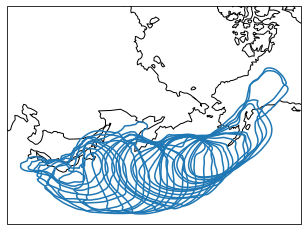

In [4]:
ax = plt.axes(projection=polar_crs)
df.boundary.plot(ax=ax)
ax.coastlines()
ax.plot([0.5, 0.5], [0,1])

# Find curious ones

<AxesSubplot:>

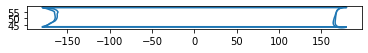

In [5]:
n = 20
broken = df.to_crs(4326).iloc[20:22]#.plot()
broken.boundary.plot()

<AxesSubplot:>

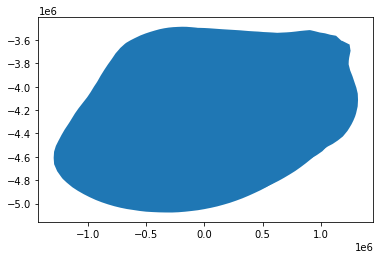

In [6]:
broken.to_crs(polar_crs).plot()

# Test if some are CW

In [7]:
polygons = df[df.geometry.geom_type=='Polygon']

In [8]:
def is_counterclockwise(polygon):
    return polygon.exterior.is_ccw

In [9]:
polygons.geometry.apply(is_counterclockwise)

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
27    True
28    True
dtype: bool

In [10]:
polygons.to_crs(4326).geometry.apply(is_counterclockwise)

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
27    True
28    True
dtype: bool

# Convert to STARE

In [11]:
sdf = starepandas.STAREDataFrame(polygons.to_crs(4326))
sids = sdf.make_sids(level=5, force_ccw=True)
sdf = sdf.set_sids(sids)
trixels = sdf.make_trixels(wrap_lon=False)
sdf = sdf.set_trixels(trixels)

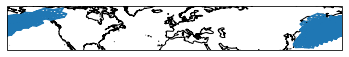

In [12]:
ax = plt.axes(projection=cartopy.crs.PlateCarree())

sdf.split_antimeridian().plot(ax=ax)
ax.coastlines()

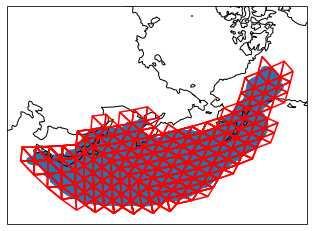

In [13]:
ax = plt.axes(projection=polar_crs)

sdf.split_antimeridian().plot(ax=ax)
polygons.plot(ax=ax)
sdf.set_geometry('trixels').to_crs(polar_crs).plot(ax=ax, color='red')
ax.coastlines()

# Construct a polygon

In [14]:
def latlon_to_xyz(latitude, longitude, altitude=0, earth_radius=1):
    # Convert degrees to radians
    lat_rad = numpy.radians(latitude)
    lon_rad = numpy.radians(longitude)

    # Convert spherical coordinates to Cartesian coordinates
    x = (earth_radius + altitude) * numpy.cos(lat_rad) * numpy.cos(lon_rad)
    y = (earth_radius + altitude) * numpy.cos(lat_rad) * numpy.sin(lon_rad)
    z = (earth_radius + altitude) * numpy.sin(lat_rad)

    return x, y, z

def xyz_to_latlon(x, y, z):
    # Assuming XYZ coordinates are in a Cartesian coordinate system
    radius = numpy.sqrt(x**2 + y**2 + z**2)

    # Calculate longitude
    lon = numpy.arctan2(y, x)

    # Calculate latitude
    lat = numpy.arcsin(z / radius)

    # Convert radians to degrees
    lon = numpy.degrees(lon)
    lat = numpy.degrees(lat)

    return lat, lon

In [15]:
# Polygon crossing antimeridian in the pacific
lons = [-100, 160, 165, -160, 170, -100]
lats = [25, 20, -25, -20, 0, 25]
polygon = shapely.geometry.Polygon(zip(lons, lats))
polygon.exterior.is_ccw

False

In [16]:
# Polygon around the south Pole
lons = [0, 90, 180, -90]
lats = [-50, -50, -50, -50]
polygon = shapely.geometry.Polygon(zip(lons, lats))
polygon.exterior.is_ccw

False

In [17]:
# Polygon around the north Pole
lons = [0, 90, 180, -90]
lats = [50, 50, 50, 50]
polygon = shapely.geometry.Polygon(zip(lons, lats))
polygon.exterior.is_ccw

False

In [18]:
gdf = geopandas.GeoDataFrame(geometry=[polygon], crs=4326)
sdf = starepandas.STAREDataFrame(gdf)
sdf = sdf.set_sids(sdf.make_sids(level=3, force_ccw=True))
sdf = sdf.set_trixels(sdf.make_trixels(wrap_lon=False) )
#sdf = sdf.split_antimeridian()

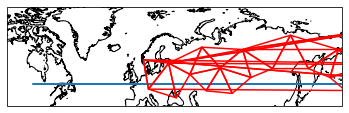

In [19]:
ax = plt.axes(projection=cartopy.crs.PlateCarree())
gdf.exterior.plot(ax=ax)
sdf.plot(ax=ax, color='red')
ax.coastlines()

In [20]:
xyz_mean = numpy.array(latlon_to_xyz(lats, lons)).mean(axis=1)
lat_center, lon_center = xyz_to_latlon(*xyz_mean)

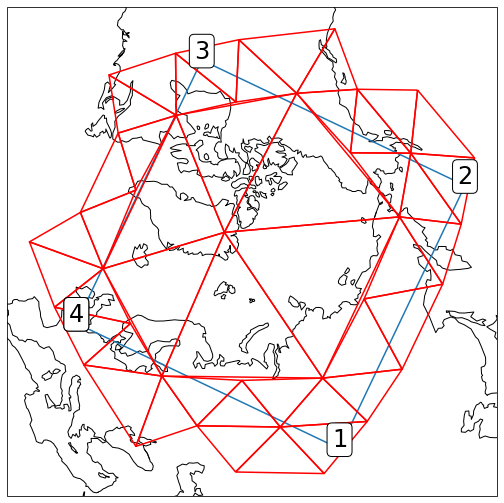

In [21]:
polar_crs = cartopy.crs.LambertAzimuthalEqualArea(central_longitude=lon_center, central_latitude=lat_center, globe=cartopy.crs.Globe())
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, projection=polar_crs)

gdf1 = gdf.to_crs(polar_crs)
gdf1.exterior.plot(ax=ax)

sdf.set_geometry('trixels', crs=4326).to_crs(polar_crs)['trixels'].boundary.plot(ax=ax, color='red')

buffer_distance = 2

for index, row in gdf1.iterrows():
    polygon = row['geometry']
    for i, (x, y) in enumerate(polygon.exterior.coords):
        ax.scatter(x, y, color='red', zorder=2)
        ax.annotate(str(i), (x, y), textcoords="offset points", xytext=(0, buffer_distance), ha='center',
                     fontsize=24, bbox=dict(boxstyle='round,pad=0.2', edgecolor='black', facecolor='white'), transform=polar_crs)
        
ax.coastlines()

In [22]:
def project_spherical_polygon(vertices):
    # Calculate centroid of the spherical polygon
    if not numpy.all(vertices[0] == vertices[-1]):
        vertices = numpy.vstack((vertices, vertices[0]))        
    centroid = numpy.mean(vertices, axis=0)

    # Compute the normal vector (centroid vector)
    normal_vector = centroid / numpy.linalg.norm(centroid)

    # Project vertices onto the plane perpendicular to the centroid vector
    projected_vertices = vertices - numpy.outer(vertices.dot(normal_vector), normal_vector)
    
    x_axis = normal_vector - numpy.array([1, 0, 0]) * normal_vector.dot([1, 0, 0])
    x_axis /= numpy.linalg.norm(x_axis)    
    y_axis = numpy.cross(normal_vector, x_axis)     
    y_axis = y_axis / numpy.linalg.norm(y_axis)       

    transformed_coordinates = numpy.dot(projected_vertices, numpy.array([x_axis, y_axis]).T)
    return transformed_coordinates


def signed_area(vertices):    
    x, y = vertices[:, 0], vertices[:, 1]    
    return 0.5 * numpy.sum(numpy.cross(numpy.roll(vertices, 1, axis=0), vertices))

def is_ccw(vertices):
    projected = project_spherical_polygon(vertices)
    area = signed_area(projected)
    if area > 0.0:
        return True
    else:
        return False

In [23]:
xs, ys, zs = latlon_to_xyz(lats, lons)
nodes = numpy.array(list(zip(xs, ys, zs)))

In [24]:
is_ccw(nodes)

True

In [25]:
is_ccw(nodes[::-1,:])

False

In [26]:
# Call the starepandas function

In [27]:
ring = gdf.iloc[0].geometry.exterior
starepandas.spatial_conversions.ring_is_ccw(ring)

True